In [1]:
# 런타임 재시작시
from google.colab import drive
drive.mount('/content/drive')

import os, torch

os.chdir("/content/drive/MyDrive/CProject/Tank-Model-Classification")
print("경로:", os.getcwd())

!git status

print("CUDA:", torch.cuda.is_available())
if torch.cuda.is_available():
    print("GPU:", torch.cuda.get_device_name(0))


Mounted at /content/drive
경로: /content/drive/MyDrive/CProject/Tank-Model-Classification
Refresh index: 100% (42/42), done.
On branch master
Your branch is up to date with 'origin/master'.

Changes not staged for commit:
  (use "git add <file>..." to update what will be committed)
  (use "git restore <file>..." to discard changes in working directory)
	modified:   tank_nontank_resnet_efficientnet.ipynb

no changes added to commit (use "git add" and/or "git commit -a")
CUDA: True
GPU: Tesla T4


In [39]:
!git status

On branch master
Your branch is up to date with 'origin/master'.

Changes not staged for commit:
  (use "git add <file>..." to update what will be committed)
  (use "git restore <file>..." to discard changes in working directory)
	modified:   tank_nontank.ipynb
	modified:   tank_nontank_resnet_efficientnet.ipynb

Untracked files:
  (use "git add <file>..." to include in what will be committed)
	efficientnet_b0_best.pth
	logs/
	resnet50_best.pth

no changes added to commit (use "git add" and/or "git commit -a")


In [34]:
!git checkout master

Switched to branch 'master'
Your branch is ahead of 'origin/master' by 1 commit.
  (use "git push" to publish your local commits)


In [35]:
!git add .

In [36]:
!git commit -m "initial_tank_nontank_models2"

[master 177a181] initial_tank_nontank_models2
 1 file changed, 1 insertion(+)
 create mode 100644 tank_nontank_resnet_efficientnet.ipynb


In [17]:
!git config --global user.email "gpwnsla1215@naver.com"
!git config --global user.name "hizoo66"

In [32]:
!git fetch origin
!git reset --hard origin/main


Updating files: 100% (42/42), done.
HEAD is now at a428fe3 clean_data_yolo_modelv1


In [33]:
!git log --oneline --decorate


a428fe3 (HEAD -> main, origin/main, origin/HEAD, master) clean_data_yolo_modelv1
4d80147 (origin/master) initial-commit


In [37]:
!git push origin master

Enumerating objects: 4, done.
Counting objects: 100% (4/4), done.
Delta compression using up to 2 threads
Compressing objects: 100% (3/3), done.
Writing objects: 100% (3/3), 3.73 KiB | 131.00 KiB/s, done.
Total 3 (delta 1), reused 0 (delta 0), pack-reused 0
remote: Resolving deltas: 100% (1/1), completed with 1 local object.
To https://github.com/hizoo66/Tank-Model-Classification.git
   4d80147..177a181  master -> master


---

### Resnet/ EfficientNet 모델 비교
YOLO → 바운딩박스 crop 데이터 셋 구성
1. 데이터 셋 구조
cls_dataset/                   
├── train  
│   ├── tank(1931)  
│   ├── car(461)  
│   ├── threewheel(482)  
│   └── motorbike(483), bus(403), truck(478), van(378)  
└── val                         
    ├── tank(801)                     
    ├── car(201)  
    └── motorbike(216), bus(185), truck(151), van(170), threewheel(227)


In [3]:
CLASS_NAMES = {
    0: "tank",
    1: "car",
    2: "threewheel",
    3: "bus",
    4: "truck",
    5: "motorbike",
    6: "van"
}


바운딩 박스 기준 CROP 함수와 클래스별 폴더 저장

In [39]:
import os
import cv2

SRC_ROOT = "tank_dataset/yolo_dataset"
DST_ROOT = "tank_dataset/cls_dataset"

def yolo_to_bbox(label, img_w, img_h):
    cls, xc, yc, w, h = map(float, label.split())
    x1 = int((xc - w/2) * img_w)
    y1 = int((yc - h/2) * img_h)
    x2 = int((xc + w/2) * img_w)
    y2 = int((yc + h/2) * img_h)
    return int(cls), max(0,x1), max(0,y1), min(img_w,x2), min(img_h,y2)


In [40]:
def build_cls_dataset(split):
    img_dir = f"{SRC_ROOT}/{split}/images"
    lbl_dir = f"{SRC_ROOT}/{split}/labels"

    for img_name in os.listdir(img_dir):
        if not img_name.endswith((".jpg", ".png")):
            continue

        img_path = os.path.join(img_dir, img_name)
        label_path = os.path.join(lbl_dir, img_name.replace(".jpg", ".txt"))

        if not os.path.exists(label_path):
            continue

        img = cv2.imread(img_path)
        h, w = img.shape[:2]

        with open(label_path) as f:
            lines = f.readlines()

        for i, line in enumerate(lines):
            cls, x1, y1, x2, y2 = yolo_to_bbox(line, w, h)
            crop = img[y1:y2, x1:x2]

            if crop.size == 0:
                continue

            cls_name = CLASS_NAMES[cls]
            save_dir = f"{DST_ROOT}/{split}/{cls_name}"
            os.makedirs(save_dir, exist_ok=True)

            save_path = f"{save_dir}/{img_name[:-4]}_{i}.jpg"
            cv2.imwrite(save_path, crop)

# 실행
build_cls_dataset("train")
build_cls_dataset("val")


----
###Dataset Loader(torchvision torch사용)
- CNN모델은 사이즈가 정해져 있음 →Resize (224, 224)
- 50% 확률로 좌우 반전(Flip)
- PIL Image → PyTorch Tensor 변환
- 픽셀값을 [0, 1] 범위로 정규화

In [4]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
])

train_ds = datasets.ImageFolder("tank_dataset/cls_dataset/train", transform=transform)
val_ds   = datasets.ImageFolder("tank_dataset/cls_dataset/val", transform=transform)

train_loader = DataLoader(train_ds, batch_size=32, shuffle=True)
val_loader   = DataLoader(val_ds, batch_size=32)


---
###Resnet과 Efficient는 학습 후 결과가 자동 저장 되지 않으므로, 평가를 위해 기록 함수 사전 준비

In [5]:
num_classes = 7
device = "cuda"

import torch
import torch.nn as nn
# Accuracy 계산
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, 1)
    return (preds == labels).float().mean().item()



In [6]:
# train loss, acc 계산
def train_one_epoch(model, loader, criterion, optimizer):
    model.train()
    total_loss, total_acc = 0, 0

    for imgs, labels in loader:
        imgs, labels = imgs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(imgs)
        loss = criterion(outputs, labels)

        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        total_acc  += accuracy(outputs, labels)

    return total_loss / len(loader), total_acc / len(loader)


In [7]:
# val loss, acc 계산
@torch.no_grad()
def validate_one_epoch(model, loader, criterion):
    model.eval()
    total_loss, total_acc = 0, 0

    for imgs, labels in loader:
        imgs, labels = imgs.to(device), labels.to(device)
        outputs = model(imgs)
        loss = criterion(outputs, labels)

        total_loss += loss.item()
        total_acc  += accuracy(outputs, labels)

    return total_loss / len(loader), total_acc / len(loader)


---
### Train 준비
- 모델 불러오기(Resnet, EfficientNet)
- 모델 학습 환경 구성(history, best_acc등)
- 기록&저장

In [8]:
from torchvision import models

def get_resnet50():
    model = models.resnet50(weights="IMAGENET1K_V2")
    model.fc = nn.Linear(model.fc.in_features, num_classes)
    return model.to(device)


In [9]:
from torchvision.models import efficientnet_b0

def get_efficientnet():
    model = efficientnet_b0(weights="IMAGENET1K_V1")
    model.classifier[1] = nn.Linear(
        model.classifier[1].in_features,
        num_classes
    )
    return model.to(device)


In [10]:
import torch.optim as optim
import copy
import csv
import os


def train_model(model, model_name, epochs=30, save_dir="logs"):
    os.makedirs(save_dir, exist_ok=True)

    csv_path = f"{save_dir}/{model_name}_history.csv"

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.AdamW(model.parameters(), lr=1e-4)

    history = {
        "train_loss": [],
        "train_acc": [],
        "val_loss": [],
        "val_acc": []
    }

    best_acc = 0
    best_epoch = 0
    best_model_wts = copy.deepcopy(model.state_dict())

    # CSV 헤더 생성
    with open(csv_path, "w", newline="") as f:
        writer = csv.writer(f)
        writer.writerow([
            "epoch",
            "train_loss",
            "train_acc",
            "val_loss",
            "val_acc"
        ])

    for epoch in range(epochs):
        tr_loss, tr_acc = train_one_epoch(
            model, train_loader, criterion, optimizer
        )
        val_loss, val_acc = validate_one_epoch(
            model, val_loader, criterion
        )

        history["train_loss"].append(tr_loss)
        history["train_acc"].append(tr_acc)
        history["val_loss"].append(val_loss)
        history["val_acc"].append(val_acc)

        # CSV에 epoch 결과 추가
        with open(csv_path, "a", newline="") as f:
            writer = csv.writer(f)
            writer.writerow([
                epoch + 1,
                round(tr_loss, 6),
                round(tr_acc, 6),
                round(val_loss, 6),
                round(val_acc, 6)
            ])

        # Best model 저장
        if val_acc > best_acc:
            best_acc = val_acc
            best_epoch = epoch + 1
            best_model_wts = copy.deepcopy(model.state_dict())
            torch.save(best_model_wts, f"{model_name}_best.pth")

        print(
            f"[{epoch+1:02d}/{epochs}] "
            f"Train Loss {tr_loss:.4f} | Acc {tr_acc:.4f} || "
            f"Val Loss {val_loss:.4f} | Acc {val_acc:.4f}"
        )

    model.load_state_dict(best_model_wts)

    return model, history, best_acc, best_epoch




In [11]:
def save_experiment_summary(
    model_name,
    best_acc,
    best_epoch,
    final_val_acc,
    save_path="logs/experiment_summary.csv"
):
    file_exists = os.path.exists(save_path)

    with open(save_path, "a", newline="") as f:
        writer = csv.writer(f)

        if not file_exists:
            writer.writerow([
                "model_name",
                "best_val_acc",
                "best_epoch",
                "final_val_acc"
            ])

        writer.writerow([
            model_name,
            round(best_acc, 6),
            best_epoch,
            round(final_val_acc, 6)
        ])


---
### Train 시작

In [12]:
resnet_model = get_resnet50()
resnet_model, resnet_hist, resnet_best_acc, resnet_best_epoch = train_model(
    resnet_model, "resnet50", epochs=30
)

save_experiment_summary(
    "resnet50",
    resnet_best_acc,
    resnet_best_epoch,
    resnet_hist["val_acc"][-1]
)


Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth


100%|██████████| 97.8M/97.8M [00:00<00:00, 198MB/s]


[01/30] Train Loss 0.4589 | Acc 0.8830 || Val Loss 0.0743 | Acc 0.9810
[02/30] Train Loss 0.0827 | Acc 0.9765 || Val Loss 0.0480 | Acc 0.9857
[03/30] Train Loss 0.0503 | Acc 0.9853 || Val Loss 0.0647 | Acc 0.9816
[04/30] Train Loss 0.0234 | Acc 0.9944 || Val Loss 0.0804 | Acc 0.9754
[05/30] Train Loss 0.0165 | Acc 0.9963 || Val Loss 0.0509 | Acc 0.9872
[06/30] Train Loss 0.0332 | Acc 0.9916 || Val Loss 0.0503 | Acc 0.9841
[07/30] Train Loss 0.0099 | Acc 0.9981 || Val Loss 0.0440 | Acc 0.9851
[08/30] Train Loss 0.0068 | Acc 0.9989 || Val Loss 0.0586 | Acc 0.9856
[09/30] Train Loss 0.0152 | Acc 0.9940 || Val Loss 0.0644 | Acc 0.9810
[10/30] Train Loss 0.0165 | Acc 0.9944 || Val Loss 0.0555 | Acc 0.9846
[11/30] Train Loss 0.0127 | Acc 0.9963 || Val Loss 0.0748 | Acc 0.9836
[12/30] Train Loss 0.0105 | Acc 0.9972 || Val Loss 0.0597 | Acc 0.9820
[13/30] Train Loss 0.0087 | Acc 0.9976 || Val Loss 0.0803 | Acc 0.9789
[14/30] Train Loss 0.0138 | Acc 0.9959 || Val Loss 0.0510 | Acc 0.9831
[15/30

In [13]:
effnet_model = get_efficientnet()
effnet_model, effnet_hist, effnet_best_acc, effnet_best_epoch = train_model(
    effnet_model, "efficientnet_b0", epochs=30
)

save_experiment_summary(
    "efficientnet_b0",
    effnet_best_acc,
    effnet_best_epoch,
    effnet_hist["val_acc"][-1]
)


Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman-7f5810bc.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b0_rwightman-7f5810bc.pth


100%|██████████| 20.5M/20.5M [00:00<00:00, 124MB/s]


[01/30] Train Loss 0.6771 | Acc 0.8435 || Val Loss 0.1229 | Acc 0.9708
[02/30] Train Loss 0.1374 | Acc 0.9595 || Val Loss 0.0670 | Acc 0.9826
[03/30] Train Loss 0.0696 | Acc 0.9821 || Val Loss 0.0610 | Acc 0.9826
[04/30] Train Loss 0.0391 | Acc 0.9894 || Val Loss 0.0634 | Acc 0.9800
[05/30] Train Loss 0.0372 | Acc 0.9899 || Val Loss 0.0606 | Acc 0.9826
[06/30] Train Loss 0.0266 | Acc 0.9935 || Val Loss 0.0418 | Acc 0.9877
[07/30] Train Loss 0.0144 | Acc 0.9968 || Val Loss 0.0491 | Acc 0.9862
[08/30] Train Loss 0.0246 | Acc 0.9918 || Val Loss 0.0487 | Acc 0.9862
[09/30] Train Loss 0.0176 | Acc 0.9942 || Val Loss 0.0573 | Acc 0.9821
[10/30] Train Loss 0.0122 | Acc 0.9976 || Val Loss 0.0579 | Acc 0.9821
[11/30] Train Loss 0.0128 | Acc 0.9972 || Val Loss 0.0498 | Acc 0.9867
[12/30] Train Loss 0.0062 | Acc 0.9989 || Val Loss 0.0511 | Acc 0.9877
[13/30] Train Loss 0.0122 | Acc 0.9961 || Val Loss 0.0503 | Acc 0.9851
[14/30] Train Loss 0.0076 | Acc 0.9983 || Val Loss 0.0462 | Acc 0.9887
[15/30

---
### 시각화
- 학습 과정
- 혼동행렬

In [14]:
import pandas as pd
import matplotlib.pyplot as plt

# 파일 경로
resnet_csv = "logs/resnet50_history.csv"
effnet_csv = "logs/efficientnet_b0_history.csv"

# CSV 읽기
resnet_df = pd.read_csv(resnet_csv)
effnet_df = pd.read_csv(effnet_csv)

# epoch column이 없으면 만들어주기
if "epoch" not in resnet_df.columns:
    resnet_df["epoch"] = range(1, len(resnet_df)+1)
if "epoch" not in effnet_df.columns:
    effnet_df["epoch"] = range(1, len(effnet_df)+1)


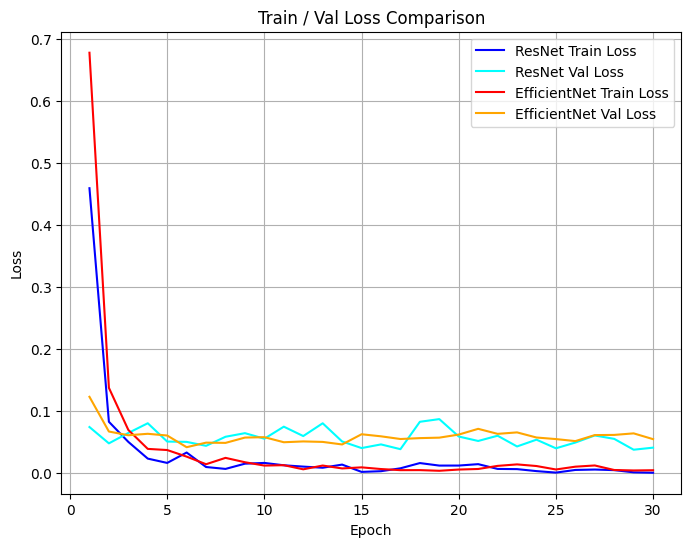

In [15]:
plt.figure(figsize=(8,6))
plt.plot(resnet_df["epoch"], resnet_df["train_loss"], label="ResNet Train Loss", color="blue")
plt.plot(resnet_df["epoch"], resnet_df["val_loss"], label="ResNet Val Loss", color="cyan")
plt.plot(effnet_df["epoch"], effnet_df["train_loss"], label="EfficientNet Train Loss", color="red")
plt.plot(effnet_df["epoch"], effnet_df["val_loss"], label="EfficientNet Val Loss", color="orange")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Train / Val Loss Comparison")
plt.legend()
plt.grid(True)
plt.show()


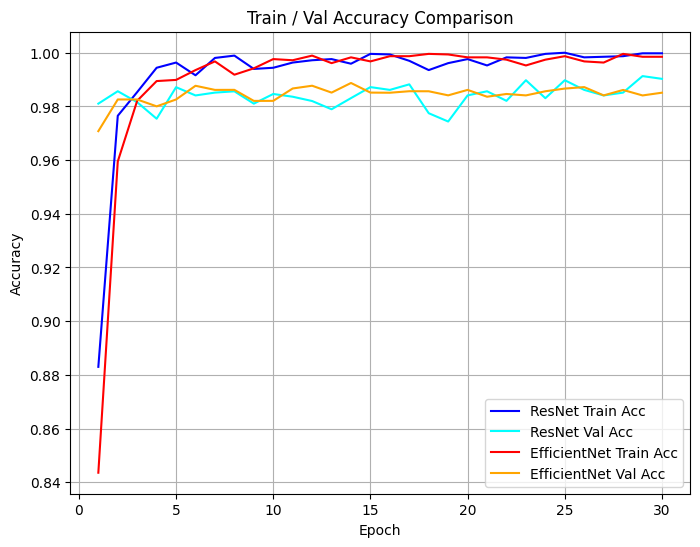

In [16]:
plt.figure(figsize=(8,6))
plt.plot(resnet_df["epoch"], resnet_df["train_acc"], label="ResNet Train Acc", color="blue")
plt.plot(resnet_df["epoch"], resnet_df["val_acc"], label="ResNet Val Acc", color="cyan")
plt.plot(effnet_df["epoch"], effnet_df["train_acc"], label="EfficientNet Train Acc", color="red")
plt.plot(effnet_df["epoch"], effnet_df["val_acc"], label="EfficientNet Val Acc", color="orange")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Train / Val Accuracy Comparison")
plt.legend()
plt.grid(True)
plt.show()


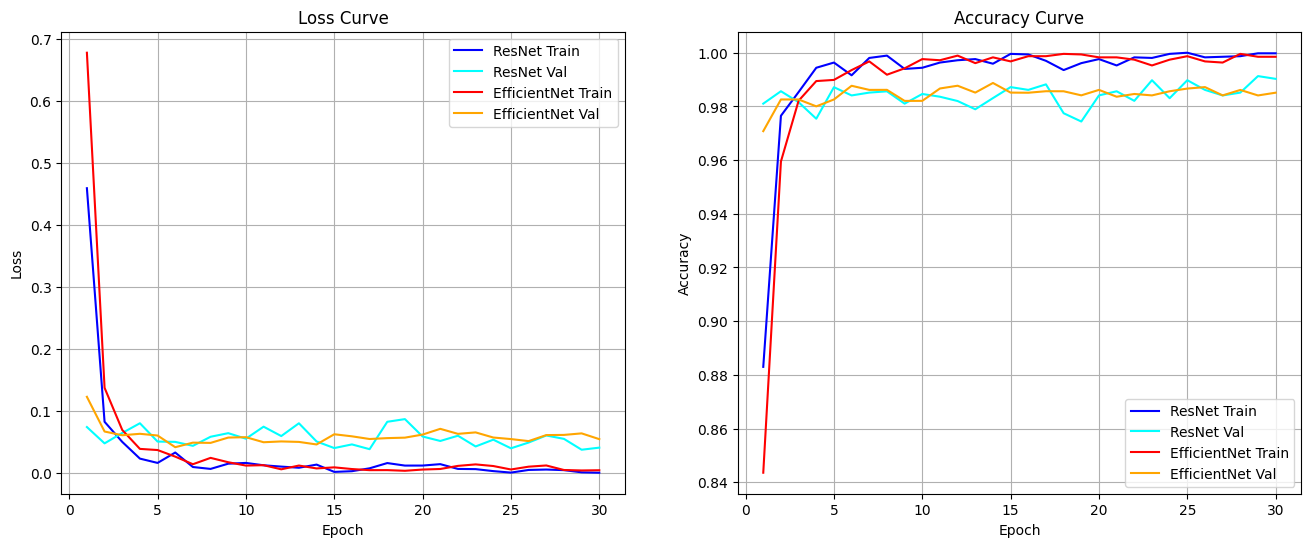

In [17]:
fig, axes = plt.subplots(1, 2, figsize=(16,6))

# Loss
axes[0].plot(resnet_df["epoch"], resnet_df["train_loss"], label="ResNet Train", color="blue")
axes[0].plot(resnet_df["epoch"], resnet_df["val_loss"], label="ResNet Val", color="cyan")
axes[0].plot(effnet_df["epoch"], effnet_df["train_loss"], label="EfficientNet Train", color="red")
axes[0].plot(effnet_df["epoch"], effnet_df["val_loss"], label="EfficientNet Val", color="orange")
axes[0].set_xlabel("Epoch")
axes[0].set_ylabel("Loss")
axes[0].set_title("Loss Curve")
axes[0].legend()
axes[0].grid(True)

# Accuracy
axes[1].plot(resnet_df["epoch"], resnet_df["train_acc"], label="ResNet Train", color="blue")
axes[1].plot(resnet_df["epoch"], resnet_df["val_acc"], label="ResNet Val", color="cyan")
axes[1].plot(effnet_df["epoch"], effnet_df["train_acc"], label="EfficientNet Train", color="red")
axes[1].plot(effnet_df["epoch"], effnet_df["val_acc"], label="EfficientNet Val", color="orange")
axes[1].set_xlabel("Epoch")
axes[1].set_ylabel("Accuracy")
axes[1].set_title("Accuracy Curve")
axes[1].legend()
axes[1].grid(True)

plt.show()


In [18]:
import torch
from sklearn.metrics import confusion_matrix
import pandas as pd
import os

def save_confusion_matrix_csv(model, loader, model_name, class_names, save_dir="logs"):
    model.eval()
    all_preds, all_labels = [], []

    with torch.no_grad():
        for imgs, labels in loader:
            imgs = imgs.to(device)
            outputs = model(imgs)
            _, preds = torch.max(outputs, 1)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.numpy())

    cm = confusion_matrix(all_labels, all_preds)

    # DataFrame으로 변환
    cm_df = pd.DataFrame(cm, index=class_names, columns=class_names)

    # 저장
    os.makedirs(save_dir, exist_ok=True)
    path = os.path.join(save_dir, f"{model_name}_confusion.csv")
    cm_df.to_csv(path)
    print(f"Confusion matrix saved to {path}")

    return cm


In [19]:
class_names = ["tank", "car", "threewheel", "bus", "truck", "motorbike", "van"]

# ResNet
resnet_cm = save_confusion_matrix_csv(resnet_model, val_loader, "resnet50", class_names)

# EfficientNet
effnet_cm = save_confusion_matrix_csv(effnet_model, val_loader, "efficientnet_b0", class_names)


Confusion matrix saved to logs/resnet50_confusion.csv
Confusion matrix saved to logs/efficientnet_b0_confusion.csv


In [20]:
resnet_cm_csv = "logs/resnet50_confusion.csv"
effnet_cm_csv = "logs/efficientnet_b0_confusion.csv"

resnet_cm = pd.read_csv(resnet_cm_csv, index_col=0).to_numpy()
effnet_cm = pd.read_csv(effnet_cm_csv, index_col=0).to_numpy()


In [23]:
import numpy as np
def plot_confusion_matrix(cm, class_names, title="Confusion Matrix"):
    plt.figure(figsize=(8,6))
    plt.imshow(cm, cmap=plt.cm.Blues)
    plt.colorbar()

    # 눈금 라벨
    plt.xticks(np.arange(len(class_names)), class_names, rotation=45)
    plt.yticks(np.arange(len(class_names)), class_names)

    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title(title)

    # 셀마다 값 표시
    for i in range(len(class_names)):
        for j in range(len(class_names)):
            plt.text(j, i, cm[i, j],
                     ha="center", va="center",
                     color="white" if cm[i, j] > cm.max()/2 else "black")

    plt.tight_layout()
    plt.show()


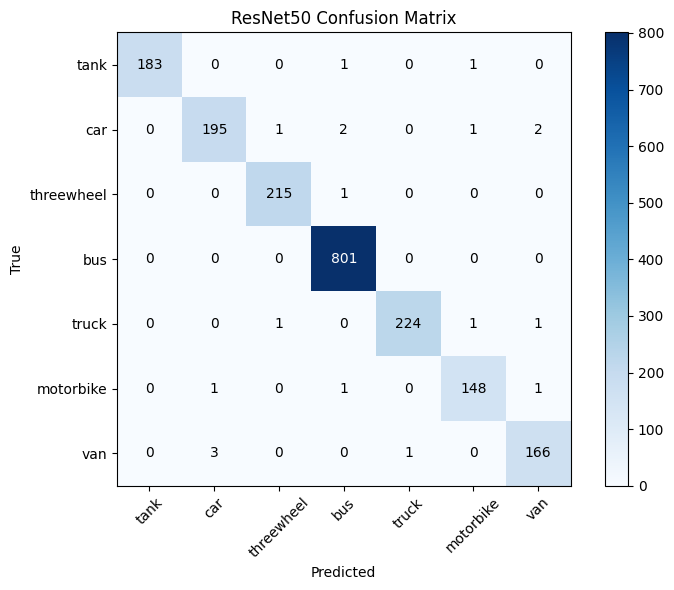

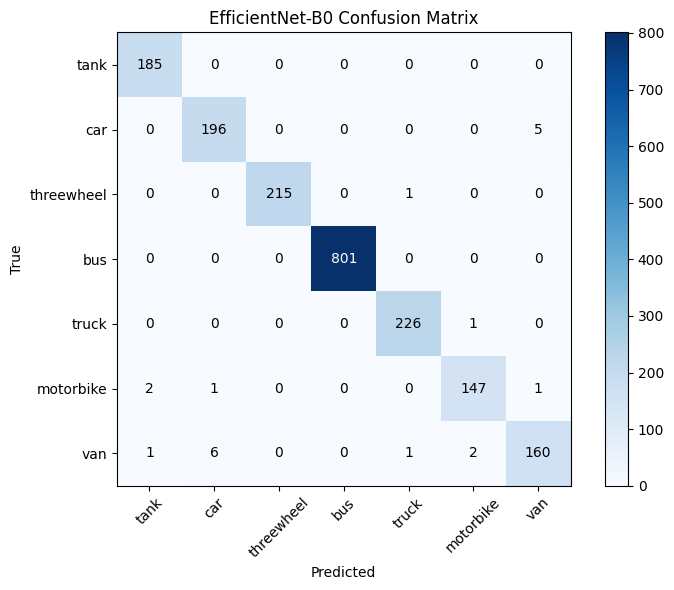

In [24]:
plot_confusion_matrix(resnet_cm, class_names, "ResNet50 Confusion Matrix")
plot_confusion_matrix(effnet_cm, class_names, "EfficientNet-B0 Confusion Matrix")
